# Part 1: Data Pre-Processing and Processing

This part of the notebook loads and pre-processes data from Challenge 1:
- Score files (2020-2023)
- Budget units
- Transaction funnel data
- Analytics data

## 1. Import Libraries

In [54]:
import pandas as pd 
import numpy as np 
import openpyxl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## 2. Define File Paths

In [5]:
# Score file paths
scores_20 = '../Data/Challenge_1/scores_20.csv'
scores_21 = '../Data/Challenge_1/scores_21.csv'
scores_22 = '../Data/Challenge_1/scores_22.csv'
scores_23 = '../Data/Challenge_1/scores_23.csv'

## 3. Concatenate Score Files

In [6]:
def concat_scores():
    """Concatenate all score files from different years."""
    dfs = []
    dfs.append(pd.read_csv(scores_20))
    dfs.append(pd.read_csv(scores_21))
    dfs.append(pd.read_csv(scores_22))
    dfs.append(pd.read_csv(scores_23))
    data_scores = pd.concat(dfs, ignore_index=True)
    return data_scores

## 4. Load All Datasets

In [8]:
# Load datasets
data_budget = pd.read_excel('../Data/Challenge_1/budget_units.xlsx')
data_funnel = pd.read_csv('../Data/Challenge_1/transactions.csv')
data_analysis = pd.read_csv('../Data/Challenge_1/analytics_data.csv')
data_scores = concat_scores()

print("All datasets loaded successfully!")

All datasets loaded successfully!


## 5. Preview Datasets

In [10]:
print("Budget Data:")
display(data_budget.head())
print(f"\nShape: {data_budget.shape}")

Budget Data:


,Trip,period_20,period_21,period_22,period_23,period_24
0,Art and Architecture in Barcelona,A,A,A,A,A
1,Beach Vacation in the Balearic Islands,B,NaN,NaN,C,NaN
2,"Castle Tour in Bavaria, Germany",B,B,C,B,NaN
3,Cheese and Chocolate Tour in Switzerland,B,B,B,B,NaN
4,Countryside Escape in Tuscany,B,B,B,B,NaN



Shape: (22, 6)


In [11]:
print("Funnel/Transaction Data:")
display(data_funnel.head())
print(f"\nShape: {data_funnel.shape}")

Funnel/Transaction Data:


,Date,Customer ID,Status,Operator ID
0,2019-01-02,8022947342,Filled in form,O3
1,2019-06-24,8646438687,Filled in form,O3
2,2019-04-04,9379000553,Filled in form,O3
3,2019-02-04,1464743096,Filled in form,O4
4,2019-04-11,8015744618,Filled in form,O1



Shape: (16120, 4)


In [12]:
print("Analytics Data:")
display(data_analysis.head())
print(f"\nShape: {data_analysis.shape}")

Analytics Data:


,trip_name,page_views,unique_visitors,avg_session_duration,bounce_rate,conversion_rate
0,Mountain Hiking in the Swiss Alps,142497,16260,23.3s,45%,1.5%
1,Kayaking in the Norwegian Fjords,96390,12282,25.2s,50%,1.2%
2,Cycling Tour in the Pyrenees,111707,14480,21.9s,48%,1.8%
3,Historical Tour of Rome,152355,20292,30.9s,40%,1.9%
4,Cultural Immersion in Prague,132790,17410,26.8s,42%,1.6%



Shape: (18, 6)


In [13]:
print("Scores Data:")
display(data_scores.head())
print(f"\nShape: {data_scores.shape}")

Scores Data:


,Trip,organization,global_satisfaction,period
0,Mountain Hiking in the Swiss Alps,6.2,5.3,3
1,Kayaking in Costa Brava,7.1,6.9,1
2,Cycling Tour in the Pyrenees,7.8,7.4,2
3,Historical Tour of Rome,8.5,7.0,4
4,Cultural Immersion in Prague,7.7,8.6,1



Shape: (74, 4)


## 6. Data Pre-Processing

#### Check for duplicates and missing values in all datasets.

In [14]:
def dup_NaN_pp():
    """Check for duplicates and missing values in all datasets."""
    data = {
        "data_budget": data_budget,
        "data_funnel": data_funnel,
        "data_analysis": data_analysis,
        "data_scores": data_scores,
    }
    
    for name, df in data.items():
        if df.duplicated().any() or df.isnull().values.any():
            print("\n-----------------------------------\n")
            print(f"Dataset: {name}")
            # print("Data information and description:")
            # df.info()
            # df.describe(include='all')

            print("\nCheck duplicates:")
            print(df.duplicated().sum())

            print("\nCheck missing or null:")
            print(df.isnull().sum())
            print("\nPercentage of missing values:")
            print(df.isnull().mean() * 100)

            print("\n-----------------------------------\n")
        else:
            print(f"\n{name} - No duplicates or missing values found.")

In [15]:
dup_NaN_pp()


-----------------------------------

Dataset: data_budget

Check duplicates:
0

Check missing or null:
Trip          0
period_20     4
period_21     5
period_22     3
period_23     2
period_24    17
dtype: int64

Percentage of missing values:
Trip          0.000000
period_20    18.181818
period_21    22.727273
period_22    13.636364
period_23     9.090909
period_24    77.272727
dtype: float64

-----------------------------------


data_funnel - No duplicates or missing values found.

data_analysis - No duplicates or missing values found.

data_scores - No duplicates or missing values found.


After the pre-processing, we can come to the conclusion to remove 'period_24' from data_budget as it is Null.

In [27]:
# Remove column with all null values
if 'period_24' in data_budget.columns:
    data_budget = data_budget.drop(columns=['period_24'])
    print("Dropped 'period_24' column from data_budget")
else:
    print("'period_24' column not found in data_budget")

print(f"\nUpdated data_budget shape: {data_budget.shape}")

'period_24' column not found in data_budget

Updated data_budget shape: (22, 5)


#### Converts dtypes to ensure consistency (nullable types)

In [28]:
def dtype_pp():
    global data_budget, data_funnel, data_analysis, data_scores
    frames = {
        "data_budget": data_budget,
        "data_funnel": data_funnel,
        "data_analysis": data_analysis,
        "data_scores": data_scores,
    }
    normalized = {}
    for name, df in frames.items():
        converted = df.convert_dtypes()
        diffs = {
            col: (df.dtypes[col], converted.dtypes[col])
            for col in df.columns
            if df.dtypes[col] != converted.dtypes[col]
        }
        if diffs:
            print(f"[dtypes] {name} conversions:")
            for col, (before, after) in diffs.items():
                print(f"  - {col}: {before} -> {after}")
        normalized[name] = converted
    data_budget = normalized["data_budget"]
    data_funnel = normalized["data_funnel"]
    data_analysis = normalized["data_analysis"]
    data_scores = normalized["data_scores"]

In [29]:
dtype_pp()

[dtypes] data_budget conversions:
  - Trip: object -> string
[dtypes] data_analysis conversions:
  - trip_name: object -> string
[dtypes] data_scores conversions:
  - Trip: object -> string


#### Any date related column (date, time, timestamp) every date is converted to proper datetime.

In [30]:
def dat_cols_pp():
    global data_budget, data_funnel, data_analysis, data_scores
    frames = {
        "data_budget": data_budget,
        "data_funnel": data_funnel,
        "data_analysis": data_analysis,
        "data_scores": data_scores,
    }
    tokens = ("date", "time", "timestamp")
    for name, df in frames.items():
        for col in df.columns:
            if any(token in col.lower() for token in tokens):
                before = df[col].isna().sum()
                converted = pd.to_datetime(
                    df[col],
                    errors="coerce",
                    infer_datetime_format=True,
                    utc=False,
                )
                if hasattr(converted, "dt"):
                    converted = converted.dt.tz_localize(None)
                df[col] = converted
                after = df[col].isna().sum()
                if after != before:
                    print(f"[dates] {name}.{col}: nulls {before}->{after}")
    data_budget = frames["data_budget"]
    data_funnel = frames["data_funnel"]
    data_analysis = frames["data_analysis"]
    data_scores = frames["data_scores"]

In [31]:
dat_cols_pp()

### Lowercase, trimming, and normalizing names 
(some activities are the same but have spelling errors or add more location info)

In [32]:
trip_aliases = {
    "forest exploration in the black forest, germany": "forest exploration in the black forest",
    "northern lights in lapland, finland": "northern lights in finland",
    "northern lights in findland": "northern lights in finland",
}

def apply_trip_aliases():
    global data_budget, data_funnel, data_analysis, data_scores
    frames = {
        "data_budget": data_budget,
        "data_funnel": data_funnel,
        "data_analysis": data_analysis,
        "data_scores": data_scores,
    }
    for df in frames.values():
        trip_cols = [col for col in df.columns if "trip" in col.lower()]
        for col in trip_cols:
            df[col] = (
                df[col]
                .astype(str)
                .str.strip()
                .str.lower()
                .replace(trip_aliases)
            )
    data_budget = frames["data_budget"]
    data_funnel = frames["data_funnel"]
    data_analysis = frames["data_analysis"]
    data_scores = frames["data_scores"]

apply_trip_aliases()

def names_pp():
    frames = {
        "data_budget": data_budget,
        "data_funnel": data_funnel,
        "data_analysis": data_analysis,
        "data_scores": data_scores,
    }
    normalized_sets = {}
    for name, df in frames.items():
        trip_cols = [col for col in df.columns if "trip" in col.lower()]
        if not trip_cols:
            continue
        col = trip_cols[0]
        normalized = (
            df[col]
            .dropna()
            .astype(str)
            .str.strip()
            .str.lower()
        )
        normalized_sets[name] = {"column": col, "values": set(normalized)}
    if not normalized_sets:
        print("[trip] No trip columns detected.")
        return
    reference_name = next(iter(normalized_sets))
    reference_values = normalized_sets[reference_name]["values"]
    for name, info in normalized_sets.items():
        missing = reference_values - info["values"]
        extra = info["values"] - reference_values
        if missing or extra:
            print(f"[trip] {name} ({info['column']}):")
            if missing:
                print(f"  Missing vs {reference_name}: {sorted(missing)[:10]}")
            if extra:
                print(f"  Extra vs {reference_name}: {sorted(extra)[:10]}")
        else:
            print(f"[trip] {name} ({info['column']}) aligns with {reference_name}.")

In [25]:
names_pp()

[trip] data_budget (Trip) aligns with data_budget.
[trip] data_analysis (trip_name):
  Missing vs data_budget: ['beach vacation in the balearic islands', 'gourmet tour of northern italy', 'kayaking in costa brava', 'skiing in andorra', 'skiing in northern catalonia', 'skiing in southern france', 'wildlife watching in the delta del ebro']
  Extra vs data_budget: ['beach vacation in the greek islands', 'kayaking in the norwegian fjords', 'wildlife watching in the scottish highlands']
[trip] data_scores (Trip) aligns with data_budget.


## Part 2: Data Analysis

This part of the notebook processes and analyzes the data we have prepared in the pre-processing.

# 1. Are Sales Decreasing?

Count sales and plot trend

In [45]:
funnel = data_funnel.copy()
sales = funnel[funnel["Status"].str.lower() == "sales"]

sales_per_year = (
    sales.assign(Year=sales["Date"].dt.year)
         .groupby("Year", dropna=False)
         .size()
         .reset_index(name="SalesCount")
         .sort_values("Year")
)

print("\nSales per year:\n", sales_per_year)


Sales per year:
    Year  SalesCount
0  2019         122
1  2020         384
2  2021         373
3  2022         369
4  2023         278


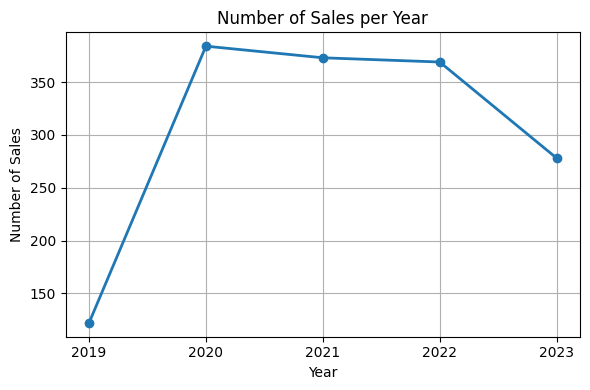

In [46]:
plt.figure(figsize=(6, 4))
plt.plot(sales_per_year["Year"], sales_per_year["SalesCount"], marker="o", linewidth=2)
plt.xticks(sales_per_year["Year"].dropna())
plt.title("Number of Sales per Year")
plt.xlabel("Year")
plt.ylabel("Number of Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
trend_data = (
    sales_per_year.dropna(subset=["Year", "SalesCount"])
    .assign(Year=lambda df: pd.to_numeric(df["Year"], errors="coerce"))
    .dropna(subset=["Year"])
    .sort_values("Year")
    .reset_index(drop=True)
)

X = trend_data[["Year"]]
y = trend_data["SalesCount"]

linreg = LinearRegression()
linreg.fit(X, y)

trend_data["PredictedSales"] = linreg.predict(X)
slope = float(linreg.coef_[0])
intercept = float(linreg.intercept_)
r_squared = float(linreg.score(X, y))

print(f"Linear trend: Sales = {slope:.2f} * Year + {intercept:.2f}")
print(f"R² score: {r_squared:.3f}")

display(trend_data)

Linear trend: Sales = 29.70 * Year + -59718.50
R² score: 0.179


,Year,SalesCount,PredictedSales
0,2019,122,245.8
1,2020,384,275.5
2,2021,373,305.2
3,2022,369,334.9
4,2023,278,364.6


As we can see, 'Year' only explains 17.9% of the variance in Sales.

# 2. Principal Component Analysis

Let's look for better explanations for Sales changes by performing a Principal Component Analysis

In [64]:
def normalize_trip_column(df):
    trip_cols = [col for col in df.columns if "trip" in col.lower()]
    if not trip_cols:
        raise ValueError("No trip-related column found.")
    col = trip_cols[0]
    return df.assign(
        trip_normalized=(
            df[col]
            .astype(str)
            .str.strip()
            .str.lower()
            .replace(trip_aliases)
        )
    )

scores_norm = normalize_trip_column(data_scores)
score_numeric_cols = scores_norm.select_dtypes(include="number").columns
scores_prep = (
    scores_norm
    .groupby("trip_normalized", as_index=False)[score_numeric_cols]
    .mean()
)

budget_norm = normalize_trip_column(data_budget)
budget_numeric_cols = budget_norm.select_dtypes(include="number").columns
budget_prep = (
    budget_norm
    .groupby("trip_normalized", as_index=False)[budget_numeric_cols]
    .mean()
)

analytics_norm = normalize_trip_column(data_analysis)
analytics_numeric = analytics_norm.drop(columns=["trip_normalized"]).apply(
    lambda col: pd.to_numeric(col.str.rstrip("%"), errors="coerce") if col.dtype == "string" else pd.to_numeric(col, errors="coerce")
)
analytics_prep = (
    pd.concat([analytics_norm[["trip_normalized"]], analytics_numeric], axis=1)
    .groupby("trip_normalized", as_index=False)
    .mean()
)

pca_base = (
    scores_prep
    .merge(budget_prep, on="trip_normalized", how="inner", suffixes=("_score", "_budget"))
    .merge(analytics_prep, on="trip_normalized", how="inner", suffixes=("", "_analytics"))
)

pca_features = (
    pca_base.drop(columns=["trip_normalized"])
    .apply(pd.to_numeric, errors="coerce")
)
pca_features = pca_features.loc[:, pca_features.notna().any(axis=0)]
pca_ready = pca_features.apply(lambda col: col.fillna(col.mean()), axis=0)
pca_ready = pca_ready.loc[:, pca_ready.std(axis=0) > 0]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_ready)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

pca_components = pd.DataFrame(
    X_pca,
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])],
    index=pca_ready.index,
)

explained_variance = pd.Series(
    pca.explained_variance_ratio_,
    index=pca_components.columns,
    name="ExplainedVariance"
)

print("Explained variance ratio by principal component:")
display(explained_variance.to_frame())

print("\nFirst principal components preview:")
display(pca_components.head())

Explained variance ratio by principal component:


,ExplainedVariance
PC1,0.575961
PC2,0.272137
PC3,0.072346
PC4,0.045223
PC5,0.021534
PC6,0.010766
PC7,0.002032



First principal components preview:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.292546,1.554593,0.386828,0.195007,0.877220,-0.334379,-0.055183
1,0.000495,-2.696402,0.293364,-0.409124,-0.023807,-0.064950,-0.093055
2,-1.798017,-0.397386,-0.160599,-0.384345,-0.314833,-0.173923,-0.010663
3,-1.627374,2.010049,-0.855905,-0.387416,-0.211010,0.365336,-0.136731
4,-0.672608,-0.005838,1.515381,-0.510354,0.130423,0.252125,0.126333


In [72]:
feature_names = pca_ready.columns
loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_names,
    columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])]
)

for pc_idx in range(7):
    pc_name = f"PC{pc_idx+1}"
    print(f"Top loadings for {pc_name}:")
    display(loadings[pc_name].reindex(loadings[pc_name].abs().sort_values(ascending=False).index).head(10))

Top loadings for PC1:


unique_visitors        0.474588
page_views             0.458178
bounce_rate           -0.443061
conversion_rate        0.427325
period                 0.369201
organization           0.215245
global_satisfaction    0.057357
Name: PC1, dtype: float64

Top loadings for PC2:


global_satisfaction   -0.645884
organization          -0.627285
period                -0.289159
page_views             0.211918
bounce_rate           -0.172640
unique_visitors        0.164064
conversion_rate        0.064061
Name: PC2, dtype: float64

Top loadings for PC3:


period                -0.715891
global_satisfaction    0.583135
bounce_rate           -0.249194
conversion_rate        0.192123
unique_visitors        0.164255
organization          -0.145383
page_views            -0.018129
Name: PC3, dtype: float64

Top loadings for PC4:


conversion_rate        0.860774
bounce_rate            0.429162
page_views            -0.221449
unique_visitors       -0.126884
global_satisfaction   -0.084798
organization          -0.050577
period                -0.000688
Name: PC4, dtype: float64

Top loadings for PC5:


bounce_rate            0.551023
page_views             0.541769
organization           0.415096
period                -0.391437
unique_visitors        0.211789
global_satisfaction   -0.153063
conversion_rate       -0.095130
Name: PC5, dtype: float64

Top loadings for PC6:


organization          -0.585611
bounce_rate            0.462474
global_satisfaction    0.425418
period                 0.335770
unique_visitors        0.306267
page_views             0.199180
conversion_rate       -0.126422
Name: PC6, dtype: float64

Top loadings for PC7:


unique_visitors       -0.752407
page_views             0.602170
global_satisfaction    0.167026
organization          -0.145752
conversion_rate        0.102053
bounce_rate           -0.100530
period                 0.040151
Name: PC7, dtype: float64

Check validity of PCA:

In [73]:
orthogonality = loadings.T @ loadings
display(pd.DataFrame(orthogonality, index=loadings.columns, columns=loadings.columns).round(6))

column_norms = np.sqrt(np.diag(orthogonality))
print("Column norms:", np.round(column_norms, 6))

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
PC1,1.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0
PC2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
PC3,-0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0
PC4,-0.0,0.0,-0.0,1.0,0.0,0.0,-0.0
PC5,-0.0,0.0,-0.0,0.0,1.0,0.0,-0.0
PC6,0.0,0.0,-0.0,0.0,0.0,1.0,-0.0
PC7,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,1.0


Column norms: [1. 1. 1. 1. 1. 1. 1.]


From the results of this PCA, we can now take PC1 and PC2 as our MLS variables.

PC1+PC2 account for almost 85% of variance.

PC1 -> Engagement

PC2 -> Perception

# 3. Mulitple Linear Regression